In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
sales_data_path = '/content/drive/My Drive/saadaa_project_data_v2/enhanced_sales_data_v2.csv'
vendor_data_path = '/content/drive/My Drive/saadaa_project_data_v2/vendor_data.csv'
inventory_data_path = '/content/drive/My Drive/saadaa_project_data_v2/inventory_data.csv'


In [3]:
import pandas as pd


# 1. Load enhanced data once
sales = pd.read_csv(sales_data_path, parse_dates=['Date'])

In [4]:
sales[sales['SKU']=="SKU002"][["Date","Units_Sold"]]

,Date,Units_Sold
1,2022-05-01,8
6,2022-05-02,7
11,2022-05-03,8
16,2022-05-04,7
21,2022-05-05,8
...,...,...
5456,2025-04-26,15
5461,2025-04-27,14
5466,2025-04-28,11
5471,2025-04-29,10


#Plot Training Data

In [6]:
import pandas as pd
import plotly.express as px

# Ensure Date is datetime
sales['Date'] = pd.to_datetime(sales['Date'])

# Filter to the 5 SKUs
skus = ["SKU001", "SKU002", "SKU003", "SKU004", "SKU005"]
df = sales[sales['SKU'].isin(skus)].sort_values('Date')

# Create an interactive grid of line plots, one row per SKU
fig = px.line(
    df,
    x='Date',
    y='Units_Sold',
    facet_row='SKU',
    height=800,
    title='Units Sold Over Time by SKU'
)
fig.update_layout(hovermode='x unified')
fig.for_each_yaxis(lambda y: y.update(title_text='Units Sold'))
fig.update_xaxes(matches=None)

fig.show()


#XGB and Finding best params

In [7]:
# calculating best params for XGB

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
import xgboost as xgb

# 1. Load enhanced data once
sales = pd.read_csv(sales_data_path, parse_dates=['Date'])

# 2. Pick a SKU (repeat in a loop for each SKU)
TARGET_SKU_LST = ['SKU001','SKU002','SKU003','SKU004','SKU005']
for TARGET_SKU in TARGET_SKU_LST:
  df = (sales[sales['SKU']==TARGET_SKU]
        .sort_values('Date')
        .reset_index(drop=True))

  # 3. Feature engineer (including new columns)
  df['dow'] = df['Date'].dt.weekday
  df['month'] = df['Date'].dt.month
  df['is_weekend'] = (df['dow']>=5).astype(int)
  for lag in [1,7,30]:
      df[f'lag_{lag}'] = df['Units_Sold'].shift(lag)
  df['roll_7']  = df['Units_Sold'].shift(1).rolling(7).mean()
  df['roll_30'] = df['Units_Sold'].shift(1).rolling(30).mean()

  # 4. Drop NaNs & split
  df_fe = df.dropna().reset_index(drop=True)
  cutoff = df_fe['Date'].max() - pd.Timedelta(days=30)
  train = df_fe[df_fe['Date']<=cutoff]
  test  = df_fe[df_fe['Date']> cutoff]

  X_train = train.drop(['Date','SKU','Style','Units_Sold'], axis=1)
  y_train = train['Units_Sold']

  # 5. Set up TimeSeriesSplit tuning
  tscv = TimeSeriesSplit(n_splits=3)
  mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

  param_dist = {
      'n_estimators':    [100,200,300],
      'max_depth':       [3,5,7],
      'learning_rate':   [0.01,0.05,0.1],
      'subsample':       [0.6,0.8,1.0],
      'colsample_bytree':[0.6,0.8,1.0],
      'reg_alpha':       [0,0.1,0.5],
      'reg_lambda':      [1,1.5,2]
  }

  model = xgb.XGBRegressor(tree_method='hist', random_state=42)
  search = RandomizedSearchCV(
      estimator=model,
      param_distributions=param_dist,
      n_iter=20,
      cv=tscv,
      scoring=mae_scorer,
      n_jobs=-1,
      random_state=42,
      verbose=1
  )

  search.fit(X_train, y_train)
  print("\n\nNew best params for", TARGET_SKU, ":", search.best_params_)
  print("Best MAE:", -search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


New best params for SKU001 : {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best MAE: 1.5983712673187256
Fitting 3 folds for each of 20 candidates, totalling 60 fits


New best params for SKU002 : {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best MAE: 1.2959544658660889
Fitting 3 folds for each of 20 candidates, totalling 60 fits


New best params for SKU003 : {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
Best MAE: 0.9471606214841207
Fitting 3 folds for each of 20 candidates, totalling 60 fits


New best params for SKU004 : {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_byt

#Assigning best params in a variable

In [9]:
best_params_by_sku = {
    'SKU001': {
        'subsample': 0.6,
        'reg_lambda': 1.5,
        'reg_alpha': 0,
        'n_estimators': 300,
        'max_depth': 3,
        'learning_rate': 0.01,
        'colsample_bytree': 1.0
    },
    'SKU002': {
        'subsample': 0.6,
        'reg_lambda': 1.5,
        'reg_alpha': 0,
        'n_estimators': 300,
        'max_depth': 3,
        'learning_rate': 0.01,
        'colsample_bytree': 1.0
    },
    'SKU003': {
        'subsample': 0.6,
        'reg_lambda': 1.5,
        'reg_alpha': 0,
        'n_estimators': 300,
        'max_depth': 3,
        'learning_rate': 0.01,
        'colsample_bytree': 1.0
    },
    'SKU004': {
        'subsample': 0.6,
        'reg_lambda': 1.5,
        'reg_alpha': 0,
        'n_estimators': 300,
        'max_depth': 3,
        'learning_rate': 0.01,
        'colsample_bytree': 1.0
    },
    'SKU005': {
        'subsample': 0.6,
        'reg_lambda': 1.5,
        'reg_alpha': 0,
        'n_estimators': 300,
        'max_depth': 3,
        'learning_rate': 0.01,
        'colsample_bytree': 1.0
    }
}
#  {
#     'SKU001': {
#         'subsample': 0.6,
#         'reg_lambda': 1.5,
#         'reg_alpha': 0,
#         'n_estimators': 300,
#         'max_depth': 3,
#         'learning_rate': 0.01,
#         'colsample_bytree': 1.0
#     },
#     'SKU002': {
#         'subsample': 0.6,
#         'reg_lambda': 1.5,
#         'reg_alpha': 0,
#         'n_estimators': 300,
#         'max_depth': 3,
#         'learning_rate': 0.01,
#         'colsample_bytree': 1.0
#     },
#     'SKU003': {
#         'subsample': 0.6,
#         'reg_lambda': 1.5,
#         'reg_alpha': 0,
#         'n_estimators': 300,
#         'max_depth': 3,
#         'learning_rate': 0.01,
#         'colsample_bytree': 1.0
#     },
#     'SKU004': {
#         'subsample': 0.6,
#         'reg_lambda': 1.5,
#         'reg_alpha': 0,
#         'n_estimators': 300,
#         'max_depth': 3,
#         'learning_rate': 0.01,
#         'colsample_bytree': 1.0
#     },
#     'SKU005': {
#         'subsample': 0.6,
#         'reg_lambda': 1.5,
#         'reg_alpha': 0,
#         'n_estimators': 300,
#         'max_depth': 3,
#         'learning_rate': 0.01,
#         'colsample_bytree': 1.0
#     }
# }


#Performace Matrix and Validation Forcasting Plots

In [10]:
# XGB

import pandas as pd
import numpy as np
import xgboost as xgb
import plotly.express as px
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 0. Define your data path ---
# sales_data_path = "path/to/your/extended_sales_data.csv"

# --- 1. Load sales data ---
sales = pd.read_csv(sales_data_path, parse_dates=['Date'])

# --- 2. Best hyperparameters found per SKU ---
best_params_by_sku = best_params_by_sku

# --- 3. Prepare loop and metrics storage ---
sku_list = list(best_params_by_sku.keys())
metrics = []

for sku in sku_list:
    # --- a) Subset & sort ---
    df = sales[sales['SKU'] == sku].sort_values('Date').reset_index(drop=True)

    # --- b) Feature engineering ---
    df['dow'] = df['Date'].dt.weekday
    df['month'] = df['Date'].dt.month
    df['is_weekend'] = (df['dow'] >= 5).astype(int)
    for lag in [1, 7, 30]:
        df[f'lag_{lag}'] = df['Units_Sold'].shift(lag)
    df['roll_7']  = df['Units_Sold'].shift(1).rolling(7).mean()
    df['roll_30'] = df['Units_Sold'].shift(1).rolling(30).mean()

    # --- c) Drop NaNs & split last 60 days as test ---
    df_fe = df.dropna().reset_index(drop=True)
    cutoff = df_fe['Date'].max() - pd.Timedelta(days=60)
    train = df_fe[df_fe['Date'] <= cutoff]
    test  = df_fe[df_fe['Date'] >  cutoff]

    X_train = train.drop(['Date','SKU','Style','Units_Sold'], axis=1)
    y_train = train['Units_Sold']
    X_test  = test.drop(['Date','SKU','Style','Units_Sold'], axis=1)
    y_test  = test['Units_Sold']

    # --- d) Train final model with best params ---
    params = best_params_by_sku[sku]
    model = xgb.XGBRegressor(tree_method='hist', random_state=42, **params)
    model.fit(X_train, y_train)

    # --- e) Predict & compute metrics ---
    preds = model.predict(X_test)
    mae  = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    # handle zeros in y_test for MAPE
    mape = np.mean(
        np.abs((y_test.values - preds) / np.where(y_test.values == 0, np.nan, y_test.values))
    ) * 100

    metrics.append({
        'SKU': sku,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    })

    # --- f) Plot Actual vs. Predicted ---
    df_plot = test[['Date']].copy()
    df_plot['Actual']    = y_test.values
    df_plot['Predicted'] = preds

    fig = px.line(
        df_plot,
        x='Date',
        y=['Actual', 'Predicted'],
        markers=True,
        title=f'{sku}: Actual vs Predicted (Last 60 Days)'
    )
    fig.update_layout(
        xaxis_title='Date',
        yaxis_title='Units Sold',
        legend_title_text=''
    )
    fig.show()

# --- 4. Summary table of metrics ---
metrics_df = pd.DataFrame(metrics)
print("\nBack-test performance per SKU:\n")
print(metrics_df.to_string(index=False))



Back-test performance per SKU:

   SKU      MAE     RMSE  MAPE (%)
SKU001 1.457047 1.929846  9.889266
SKU002 1.338593 1.750297 11.809006
SKU003 0.926216 1.113268 11.050227
SKU004 0.992238 1.188426 10.728463
SKU005 0.748645 0.962913 10.583230


#Comparing Multiple Models and Their Performances




In [11]:
# comparing multiple models
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 0. Load data
sales = pd.read_csv(sales_data_path, parse_dates=['Date'])

# 1. Best XGB params
best_params= best_params_by_sku

# 2. FE + split helpers
def featurize(df):
    df = df.sort_values('Date').copy()
    df['dow'] = df['Date'].dt.weekday
    df['month'] = df['Date'].dt.month
    df['is_weekend'] = (df['dow'] >= 5).astype(int)
    for lag in [1,7,30]:
        df[f'lag_{lag}'] = df['Units_Sold'].shift(lag)
    df['roll_7']  = df['Units_Sold'].shift(1).rolling(7).mean()
    df['roll_30'] = df['Units_Sold'].shift(1).rolling(30).mean()
    return df.dropna().reset_index(drop=True)

def split_last_n(df_fe, n=60):
    cutoff = df_fe['Date'].max() - pd.Timedelta(days=n)
    train = df_fe[df_fe['Date'] <= cutoff]
    test  = df_fe[df_fe['Date'] >  cutoff]
    X_tr = train.drop(['Date','SKU','Style','Units_Sold'], axis=1);  y_tr = train['Units_Sold']
    X_te = test.drop (['Date','SKU','Style','Units_Sold'], axis=1);  y_te = test['Units_Sold']
    return train, test, X_tr, y_tr, X_te, y_te

# 3. Models to test
def get_models(sku):
    return {
        'XGB':    xgb.XGBRegressor(tree_method='hist', random_state=42, **best_params[sku]),
        'RF':     RandomForestRegressor(n_jobs=-1, random_state=42),
        'LGBM':   LGBMRegressor(n_jobs=-1, random_state=42),
        'Prophet': Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    }

# 4. Loop & evaluate
results = []

for sku in best_params:
    df0 = sales[sales['SKU']==sku]
    df_fe = featurize(df0)
    train, test, X_tr, y_tr, X_te, y_te = split_last_n(df_fe, 60)

    models = get_models(sku)

    for name, model in models.items():
        if name == 'Prophet':
            # Prepare for Prophet
            df_prop = train[['Date','Units_Sold']].rename(columns={'Date':'ds','Units_Sold':'y'})
            model.fit(df_prop)
            future = test[['Date']].rename(columns={'Date':'ds'})
            forecast = model.predict(future)
            preds = forecast['yhat'].values
        else:
            # Tabular models
            model.fit(X_tr, y_tr)
            preds = model.predict(X_te)

        mae  = mean_absolute_error(y_te, preds)
        rmse = np.sqrt(mean_squared_error(y_te, preds))
        mape = np.mean(
            np.abs((y_te.values - preds) / np.where(y_te.values==0, np.nan, y_te.values))
        ) * 100

        results.append({
            'SKU': sku,
            'Model': name,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape
        })

# 5. Summary
metrics_df = pd.DataFrame(results)
print(metrics_df.pivot_table(
    index='SKU', columns='Model',
    values=['MAE','RMSE','MAPE (%)']
).round(3))


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/qfdafi07.json


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 11
[LightGBM] [Info] Start training from score 11.949304


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/htmzeasp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93650', 'data', 'file=/tmp/tmp3w9f6egd/qfdafi07.json', 'init=/tmp/tmp3w9f6egd/htmzeasp.json', 'output', 'file=/tmp/tmp3w9f6egd/prophet_modelr_nk2x65/prophet_model-20250514065600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:56:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:56:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/u3isleoe.json


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 11
[LightGBM] [Info] Start training from score 9.423459


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/ut8x0o09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3174', 'data', 'file=/tmp/tmp3w9f6egd/u3isleoe.json', 'init=/tmp/tmp3w9f6egd/ut8x0o09.json', 'output', 'file=/tmp/tmp3w9f6egd/prophet_model66r9t0kf/prophet_model-20250514065602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:56:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:56:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/4esyekwv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/x9my5nfq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bi

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 11
[LightGBM] [Info] Start training from score 6.957256


06:56:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/frr33e2v.json


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 11
[LightGBM] [Info] Start training from score 8.158052


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/nmcxzfr8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13016', 'data', 'file=/tmp/tmp3w9f6egd/frr33e2v.json', 'init=/tmp/tmp3w9f6egd/nmcxzfr8.json', 'output', 'file=/tmp/tmp3w9f6egd/prophet_model4q5t36un/prophet_model-20250514065604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:56:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:56:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/7x4r9p_5.json


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 488
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 11
[LightGBM] [Info] Start training from score 5.699801


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/634k4x6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22776', 'data', 'file=/tmp/tmp3w9f6egd/7x4r9p_5.json', 'init=/tmp/tmp3w9f6egd/634k4x6a.json', 'output', 'file=/tmp/tmp3w9f6egd/prophet_model1o0w380z/prophet_model-20250514065606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:56:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:56:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


          MAE                       MAPE (%)                           RMSE  \
Model    LGBM Prophet     RF    XGB     LGBM Prophet      RF     XGB   LGBM   
SKU                                                                           
SKU001  1.523   1.615  1.377  1.457   10.426  11.457   9.419   9.889  1.955   
SKU002  1.267   1.485  1.362  1.339   11.558  13.910  12.071  11.809  1.567   
SKU003  0.782   0.913  0.918  0.926    9.623  11.138  11.250  11.050  0.983   
SKU004  0.925   1.126  1.041  0.992   10.328  12.624  11.127  10.728  1.169   
SKU005  0.687   0.674  0.702  0.749    9.885   9.914  10.021  10.583  0.841   

                              
Model  Prophet     RF    XGB  
SKU                           
SKU001   2.130  1.848  1.930  
SKU002   1.899  1.782  1.750  
SKU003   1.162  1.156  1.113  
SKU004   1.409  1.259  1.188  
SKU005   0.826  0.926  0.963  


#Hyperparameter tuning with top 2 best performing model

In [12]:
# hypertuning params

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 0. Load your data
sales = pd.read_csv(sales_data_path, parse_dates=['Date'])

# 1. Your tuned XGB params
best_params_by_sku = best_params_by_sku

# 2. Which two models to ensemble per SKU (by MAE ranking)
top2 = {
    'SKU001': ['RF',   'XGB'],
    'SKU002': ['LGBM', 'XGB'],
    'SKU003': ['LGBM', 'Prophet'],
    'SKU004': ['LGBM', 'XGB'],
    'SKU005': ['Prophet','LGBM'],
}

# 3. FE + split helpers
def featurize(df):
    df = df.sort_values('Date').copy()
    df['dow'] = df['Date'].dt.weekday
    df['month'] = df['Date'].dt.month
    df['is_weekend'] = (df['dow'] >= 5).astype(int)
    for lag in [1,7,30]:
        df[f'lag_{lag}'] = df['Units_Sold'].shift(lag)
    df['roll_7']  = df['Units_Sold'].shift(1).rolling(7).mean()
    df['roll_30'] = df['Units_Sold'].shift(1).rolling(30).mean()
    return df.dropna().reset_index(drop=True)

def split_last_n(df_fe, n=60):
    cutoff = df_fe['Date'].max() - pd.Timedelta(days=n)
    train = df_fe[df_fe['Date'] <= cutoff]
    test  = df_fe[df_fe['Date'] >  cutoff]
    X_tr = train.drop(['Date','SKU','Style','Units_Sold'], axis=1);  y_tr = train['Units_Sold']
    X_te = test.drop (['Date','SKU','Style','Units_Sold'], axis=1);  y_te = test['Units_Sold']
    return train, test, X_tr, y_tr, X_te, y_te

# 4. Helper to fit & predict a single model
def predict_model(name, sku, train, test, X_tr, y_tr, X_te):
    if name == 'RF':
        m = RandomForestRegressor(n_jobs=-1, random_state=42)
        m.fit(X_tr, y_tr)
        return m.predict(X_te)
    elif name == 'XGB':
        m = xgb.XGBRegressor(tree_method='hist', random_state=42, **best_params_by_sku[sku])
        m.fit(X_tr, y_tr)
        return m.predict(X_te)
    elif name == 'LGBM':
        m = LGBMRegressor(n_jobs=-1, random_state=42)
        m.fit(X_tr, y_tr)
        return m.predict(X_te)
    elif name == 'Prophet':
        dfp = train[['Date','Units_Sold']].rename(columns={'Date':'ds','Units_Sold':'y'})
        m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        m.fit(dfp)
        fut = test[['Date']].rename(columns={'Date':'ds'})
        fc = m.predict(fut)
        return fc['yhat'].values
    else:
        raise ValueError(f"Unknown model {name}")

# 5. Loop over SKUs and compute ensemble
ensemble_results = []

for sku in best_params_by_sku:
    df0   = sales[sales['SKU']==sku]
    df_fe = featurize(df0)
    train, test, X_tr, y_tr, X_te, y_te = split_last_n(df_fe, 60)

    # get preds for each of the two models
    m1, m2 = top2[sku]
    p1 = predict_model(m1, sku, train, test, X_tr, y_tr, X_te)
    p2 = predict_model(m2, sku, train, test, X_tr, y_tr, X_te)

    # simple average ensemble
    ensemble_preds = (p1 + p2) / 2

    # compute metrics
    mae  = mean_absolute_error(y_te, ensemble_preds)
    rmse = np.sqrt(mean_squared_error(y_te, ensemble_preds))
    mape = np.mean(np.abs((y_te.values - ensemble_preds) / np.where(y_te.values==0, np.nan, y_te.values))) * 100

    ensemble_results.append({
        'SKU': sku,
        'Ensemble': f"{m1}+{m2}",
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    })

# 6. Report
ensemble_df = pd.DataFrame(ensemble_results)
print("\nEnsemble performance:\n", ensemble_df.to_string(index=False))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 11
[LightGBM] [Info] Start training from score 9.423459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 11
[LightGBM] [Info] Start training from score 6.957256


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/xxvbnrj2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/tbx3zrcf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42232', 'data', 'file=/tmp/tmp3w9f6egd/xxvbnrj2.json', 'init=/tmp/tmp3w9f6egd/tbx3zrcf.json', 'output', 'file=/tmp/tmp3w9f6egd/prophet_model9or1ge79/prophet_model-20250514070338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:03:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:03:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 11
[LightGBM] [Info] Start training from score 8.158052


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/ce7jiolk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/ee0nar5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60875', 'data', 'file=/tmp/tmp3w9f6egd/ce7jiolk.json', 'init=/tmp/tmp3w9f6egd/ee0nar5g.json', 'output', 'file=/tmp/tmp3w9f6egd/prophet_modelzf4151xq/prophet_model-20250514070338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:03:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:03:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 488
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 11
[LightGBM] [Info] Start training from score 5.699801

Ensemble performance:
    SKU     Ensemble      MAE     RMSE  MAPE (%)
SKU001       RF+XGB 1.409440 1.874656  9.594128
SKU002     LGBM+XGB 1.250918 1.606163 11.191598
SKU003 LGBM+Prophet 0.838831 1.015019 10.276477
SKU004     LGBM+XGB 0.931577 1.123114 10.232691
SKU005 Prophet+LGBM 0.634109 0.779768  9.172348


#Final Combination of model based on Ensemble Performance

In [13]:
# final models

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.express as px

# 1. Load data
sales = pd.read_csv(sales_data_path, parse_dates=['Date'])

# 2. Define hyperparameters for XGBoost
best_params_by_sku = best_params_by_sku

# 3. Define best approach per SKU
best_approach_by_sku = {
    'SKU001': ['RF'],
    'SKU002': ['LGBM',"XGB"],
    'SKU003': ['LGBM'],
    'SKU004': ['LGBM'],
    'SKU005': ['Prophet',"LGBM"],
}

# 4. Feature engineering and split functions
def featurize(df):
    df = df.sort_values('Date').copy()
    df['dow'] = df['Date'].dt.weekday
    df['month'] = df['Date'].dt.month
    df['is_weekend'] = (df['dow'] >= 5).astype(int)
    for lag in [1, 7, 30]:
        df[f'lag_{lag}'] = df['Units_Sold'].shift(lag)
    df['roll_7'] = df['Units_Sold'].shift(1).rolling(7).mean()
    df['roll_30'] = df['Units_Sold'].shift(1).rolling(30).mean()
    return df.dropna().reset_index(drop=True)

def split_last_n(df_fe, n=60):
    cutoff = df_fe['Date'].max() - pd.Timedelta(days=n)
    train = df_fe[df_fe['Date'] <= cutoff]
    test  = df_fe[df_fe['Date'] >  cutoff]
    X_tr = train.drop(['Date','SKU','Style','Units_Sold'], axis=1)
    y_tr = train['Units_Sold']
    X_te = test.drop(['Date','SKU','Style','Units_Sold'], axis=1)
    y_te = test['Units_Sold']
    return train, test, X_tr, y_tr, X_te, y_te

# 5. Helper to fit & predict a single model
def predict_model(name, sku, train, test, X_tr, y_tr, X_te):
    if name == 'RF':
        m = RandomForestRegressor(n_jobs=-1, random_state=42)
        m.fit(X_tr, y_tr)
        return m.predict(X_te)
    elif name == 'LGBM':
        m = LGBMRegressor(n_jobs=-1, random_state=42)
        m.fit(X_tr, y_tr)
        return m.predict(X_te)
    elif name == 'XGB':
        m = xgb.XGBRegressor(tree_method='hist', random_state=42, **best_params_by_sku[sku])
        m.fit(X_tr, y_tr)
        return m.predict(X_te)
    elif name == 'Prophet':
        dfp = train[['Date','Units_Sold']].rename(columns={'Date':'ds','Units_Sold':'y'})
        m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        m.fit(dfp)
        fut = test[['Date']].rename(columns={'Date':'ds'})
        fc = m.predict(fut)
        return fc['yhat'].values
    else:
        raise ValueError(f"Unknown model {name}")

# 6. Loop over SKUs and evaluate
ensemble_results = []
for sku, approaches in best_approach_by_sku.items():
    df0 = sales[sales['SKU'] == sku]
    df_fe = featurize(df0)
    train, test, X_tr, y_tr, X_te, y_te = split_last_n(df_fe, 60)

    # Get predictions for each selected model
    preds_list = [predict_model(mn, sku, train, test, X_tr, y_tr, X_te) for mn in approaches]
    # If multiple, average; else take single
    preds = np.mean(preds_list, axis=0) if len(preds_list) > 1 else preds_list[0]

    # Compute metrics
    mae  = mean_absolute_error(y_te, preds)
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    mape = np.mean(np.abs((y_te.values - preds) / np.where(y_te.values == 0, np.nan, y_te.values))) * 100

    ensemble_results.append({
        'SKU':        sku,
        'Approach':   '+'.join(approaches),
        'MAE':        mae,
        'RMSE':       rmse,
        'MAPE (%)':   mape
    })

    # Interactive plot
    df_plot = test[['Date']].copy()
    df_plot['Actual'] = y_te.values
    df_plot['Predicted'] = preds
    fig = px.line(
        df_plot, x='Date', y=['Actual','Predicted'], markers=True,
        title=f"{sku}: Actual vs Predicted ({'+'.join(approaches)})"
    )
    fig.update_layout(xaxis_title='Date', yaxis_title='Units Sold', legend_title_text='')
    fig.show()

# 7. Results table
ensemble_df = pd.DataFrame(ensemble_results)
ensemble_df



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 11
[LightGBM] [Info] Start training from score 9.423459


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 11
[LightGBM] [Info] Start training from score 6.957256


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 11
[LightGBM] [Info] Start training from score 8.158052


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/tzvg4qjn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/bpyh0ifd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70654', 'data', 'file=/tmp/tmp3w9f6egd/tzvg4qjn.json', 'init=/tmp/tmp3w9f6egd/bpyh0ifd.json', 'output', 'file=/tmp/tmp3w9f6egd/prophet_model8zxun13a/prophet_model-20250514070415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:04:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:04:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 488
[LightGBM] [Info] Number of data points in the train set: 1006, number of used features: 11
[LightGBM] [Info] Start training from score 5.699801


,SKU,Approach,MAE,RMSE,MAPE (%)
0,SKU001,RF,1.377167,1.848169,9.419229
1,SKU002,LGBM+XGB,1.250918,1.606163,11.191598
2,SKU003,LGBM,0.781953,0.983448,9.622830
3,SKU004,LGBM,0.924911,1.168832,10.328451
4,SKU005,Prophet+LGBM,0.634109,0.779768,9.172348


In [ ]:
# Ensemble performance:
#     SKU     Ensemble      MAE     RMSE  MAPE (%)
# SKU001       RF+XGB 1.409440 1.874656  9.594128
# SKU002     LGBM+XGB 1.250918 1.606163 11.191598
# SKU003 LGBM+Prophet 0.838831 1.015019 10.276477
# SKU004     LGBM+XGB 0.931577 1.123114 10.232691
# SKU005 Prophet+LGBM 0.634109 0.779768  9.172348

#Training on whole data for next 30 days forcasting

In [14]:
# next 30 days forcasting
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from prophet import Prophet
import math

# 1. Load your sales history
sales = pd.read_csv(sales_data_path, parse_dates=['Date'])

# 2. SKU-specific XGB hyperparameters
best_params_by_sku = best_params_by_sku
# 3. Ensemble recipe per SKU
best_approach_by_sku = {
    'SKU001': ['RF'],
    'SKU002': ['LGBM', 'XGB'],
    'SKU003': ['LGBM'],
    'SKU004': ['LGBM'],
    'SKU005': ['Prophet', 'LGBM'],
}

# 4. Feature engineering for tree models
def featurize(df):
    df = df.sort_values('Date').copy()
    df['dow'] = df['Date'].dt.weekday
    df['month'] = df['Date'].dt.month
    df['is_weekend'] = (df['dow'] >= 5).astype(int)
    for lag in [1, 7, 30]:
        df[f'lag_{lag}'] = df['Units_Sold'].shift(lag)
    df['roll_7'] = df['Units_Sold'].shift(1).rolling(7).mean()
    df['roll_30'] = df['Units_Sold'].shift(1).rolling(30).mean()
    return df.dropna().reset_index(drop=True)

# 5. Train a single model on full history
def train_model(name, sku, df_hist):
    if name in ('RF', 'LGBM', 'XGB'):
        fe = featurize(df_hist)
        X = fe.drop(['Date','SKU','Style','Units_Sold'], axis=1)
        y = fe['Units_Sold']
        if name == 'RF':
            m = RandomForestRegressor(n_jobs=-1, random_state=42)
        elif name == 'LGBM':
            m = LGBMRegressor(n_jobs=-1, random_state=42)
        else:  # XGB
            m = xgb.XGBRegressor(tree_method='hist', random_state=42, **best_params_by_sku[sku])
        m.fit(X, y)
        return m
    else:
        dfp = df_hist[['Date','Units_Sold']].rename(columns={'Date':'ds','Units_Sold':'y'})
        m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        m.fit(dfp)
        return m

# 6. One-step recursive forecast for tree & Prophet ensemble
def recursive_ml_predict(models, history, next_date):
    # create one-row placeholder
    placeholder = pd.DataFrame([{
        'Date':        next_date,
        'SKU':         history['SKU'].iat[0],
        'Style':       history['Style'].iat[0],
        'Units_Sold':  np.nan
    }])
    temp = pd.concat([history, placeholder], ignore_index=True)
    fe = featurize(temp).iloc[[-1]]
    Xp = fe.drop(['Date','SKU','Style','Units_Sold'], axis=1)
    preds = []
    for m in models:
        if isinstance(m, Prophet):
            fut = pd.DataFrame({'ds': [next_date]})
            preds.append(m.predict(fut)['yhat'].iloc[0])
        else:
            preds.append(m.predict(Xp)[0])
    return float(np.mean(preds))

# 7. Generate 30-day out-of-sample forecast for each SKU
all_forecasts = []
last_date = sales['Date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

for sku, approaches in best_approach_by_sku.items():
    df0 = sales[sales['SKU'] == sku][['Date','SKU','Style','Units_Sold']].copy()
    models = [train_model(mn, sku, df0) for mn in approaches]
    history = df0.copy()

    for d in future_dates:
        p = recursive_ml_predict(models, history, d)
        new_row = pd.DataFrame([{
            'Date':       d,
            'SKU':        sku,
            'Style':      history['Style'].iat[0],
            'Units_Sold': math.ceil(p)
        }])
        history = pd.concat([history, new_row], ignore_index=True)

    all_forecasts.append(history[history['Date'] > last_date])

# 8. Consolidate into one DataFrame
next30_df = pd.concat(all_forecasts, ignore_index=True)
next30_df = next30_df.rename(columns={'Units_Sold': 'Forecast_Units'})

# 9. Inspect or save
print(next30_df.head())
next30_df.to_csv('next_30_day_forecast.csv', index=False)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 321
[LightGBM] [Info] Number of data points in the train set: 1066, number of used features: 8
[LightGBM] [Info] Start training from score 9.507505
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 1066, number of used features: 8
[LightGBM] [Info] Start training from score 7.028143
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/kmmc2rc9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3w9f6egd/o6_mknht.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96312', 'data', 'file=/tmp/tmp3w9f6egd/kmmc2rc9.json', 'init=/tmp/tmp3w9f6egd/o6_mknht.json', 'output', 'file=/tmp/tmp3w9f6egd/prophet_modelbvj6tmva/prophet_model-20250514070458.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:04:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:04:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 1066, number of used features: 8
[LightGBM] [Info] Start training from score 5.763602
        Date     SKU  Style  Forecast_Units
0 2025-05-01  SKU001  Shirt              14
1 2025-05-02  SKU001  Shirt              14
2 2025-05-03  SKU001  Shirt              14
3 2025-05-04  SKU001  Shirt              17
4 2025-05-05  SKU001  Shirt              21


In [15]:
next30_df[next30_df['SKU']=='SKU001']

,Date,SKU,Style,Forecast_Units
0,2025-05-01,SKU001,Shirt,14
1,2025-05-02,SKU001,Shirt,14
2,2025-05-03,SKU001,Shirt,14
3,2025-05-04,SKU001,Shirt,17
4,2025-05-05,SKU001,Shirt,21
5,2025-05-06,SKU001,Shirt,13
6,2025-05-07,SKU001,Shirt,14
7,2025-05-08,SKU001,Shirt,14
8,2025-05-09,SKU001,Shirt,15
9,2025-05-10,SKU001,Shirt,15


#plotting forcasting

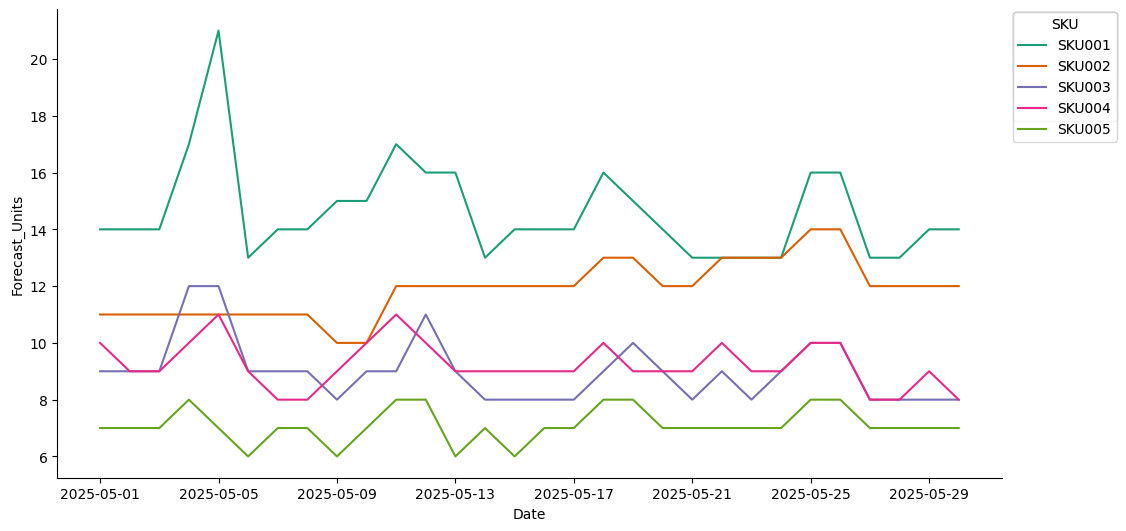

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Forecast_Units']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = next30_df.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('SKU')):
  _plot_series(series, series_name, i)
  fig.legend(title='SKU', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Forecast_Units')

#Vendor Allocation

In [16]:
import pandas as pd

# Step 1: Load data
print("📌 Loading Data...")
vendor_df = pd.read_csv('/content/drive/My Drive/saadaa_project_data_v2/vendor_data.csv')
forecast_df = pd.read_csv("next_30_day_forecast.csv")
inventory_df = pd.DataFrame({
    "SKU": ["SKU001","SKU002","SKU003","SKU004","SKU005"],
    "On_Hand_Qty": [100,110,20,80,30]
})
po_df = pd.DataFrame({
    "SKU": ["SKU001","SKU002","SKU003","SKU004","SKU005"],
    "Incoming_PO_Qty": [50,20,40,30,10]
})

# Step 2: Compute adjusted net requirements
print("\n📌 Calculating Adjusted Net Requirements...")
total_for = forecast_df.groupby("SKU")["Forecast_Units"].sum().reset_index()
req_df = (
    total_for
    .merge(inventory_df, on="SKU")
    .merge(po_df, on="SKU", how="left")
    .fillna(0)
)
req_df["Adjusted_Net_Req"] = (
    req_df["Forecast_Units"]
    - req_df["On_Hand_Qty"]
    - req_df["Incoming_PO_Qty"]
).clip(lower=0).astype(int)

print("\n📊 Adjusted Net Requirements:")
print(req_df[["SKU","Forecast_Units","On_Hand_Qty","Incoming_PO_Qty","Adjusted_Net_Req"]])

allocations = []

# Step 3: Allocation loop
for _, req in req_df.iterrows():
    sku = req["SKU"]
    need = req["Adjusted_Net_Req"]
    print(f"\n🟡 SKU {sku}: need {need} units")

    # prepare vendor pool
    pool = vendor_df[vendor_df["SKU"]==sku].copy()
    pool["Max_Supply"] = pool["Daily_Capacity"] * pool["Lead_Time_Days"]
    pool = pool.sort_values("MOQ")  # lowest-MOQ first

    allocated = 0
    temp = []

    # — Phase 1: allocate to new vendors if remaining >= MOQ & within capacity
    for _, v in pool.iterrows():
        if allocated >= need:
            break
        rem = need - allocated
        if rem >= v.MOQ and v.Max_Supply >= v.MOQ:
            qty = min(rem, v.Max_Supply)
            temp.append({
                "SKU": sku,
                "Vendor": v.Vendor,
                "Allocated_Qty": int(qty),
                "MOQ": int(v.MOQ),
                "Max_Supply": int(v.Max_Supply)
            })
            allocated += qty
            print(f"  ✅ {v.Vendor} allocated {qty} (rem ➔ {need-allocated})")
        else:
            print(f"  ❌ Skipping {v.Vendor} (rem={rem} < MOQ={v.MOQ} or cap<MOOQ)")

    # — Phase 2: top up existing vendors within their capacity
    rem = need - allocated
    if rem>0 and temp:
        print(f"🔄 Topping up {rem} units on already-used vendors (within cap)")
        for entry in temp:
            if rem<=0: break
            cap = entry["Max_Supply"]
            used = entry["Allocated_Qty"]
            spare = cap - used
            if spare>0:
                add = min(spare, rem)
                entry["Allocated_Qty"] += int(add)
                allocated += add
                rem -= add
                print(f"    🔼 +{add} to {entry['Vendor']} (now {entry['Allocated_Qty']}, rem={rem})")

    # — Phase 3: if still rem > 0, dump it all on vendor with lowest MOQ
    rem = need - allocated
    if rem>0:
        lowest = pool.iloc[0]  # lowest MOQ vendor
        print(f"⚠️ {rem} units still unmet → adding to {lowest.Vendor} (lowest MOQ)")
        # find or create its entry
        found = next((e for e in temp if e["Vendor"]==lowest.Vendor), None)
        if found:
            found["Allocated_Qty"] += int(rem)
        else:
            temp.append({
                "SKU": sku,
                "Vendor": lowest.Vendor,
                "Allocated_Qty": int(rem),
                "MOQ": int(lowest.MOQ),
                "Max_Supply": int(lowest.Max_Supply)
            })
        allocated += rem
        rem = 0
        print(f"  ✅ {lowest.Vendor} now has {next(e for e in temp if e['Vendor']==lowest.Vendor)['Allocated_Qty']}")

    # final check
    print(f"▶️ Total allocated={allocated} of {need}\n")
    allocations.extend(temp)

# Step 4: Show final allocations and verify
alloc_df = pd.DataFrame(allocations)
verify = (
    alloc_df.groupby("SKU")["Allocated_Qty"]
    .sum()
    .reset_index()
    .merge(req_df[["SKU","Adjusted_Net_Req"]], on="SKU")
)
verify["Diff"] = verify["Adjusted_Net_Req"] - verify["Allocated_Qty"]

print("📊 Verification (Diff should be 0):")
print(verify)
print("\n🏁 Final Allocations:")
print(alloc_df.reset_index(drop=True))
alloc_df.to_csv("final_allocation.csv")


📌 Loading Data...

📌 Calculating Adjusted Net Requirements...

📊 Adjusted Net Requirements:
      SKU  Forecast_Units  On_Hand_Qty  Incoming_PO_Qty  Adjusted_Net_Req
0  SKU001             438          100               50               288
1  SKU002             357          110               20               227
2  SKU003             270           20               40               210
3  SKU004             277           80               30               167
4  SKU005             213           30               10               173

🟡 SKU SKU001: need 288 units
  ✅ VendorC allocated 60 (rem ➔ 228)
  ✅ VendorA allocated 70 (rem ➔ 158)
  ✅ VendorB allocated 77 (rem ➔ 81)
🔄 Topping up 81 units on already-used vendors (within cap)
⚠️ 81 units still unmet → adding to VendorC (lowest MOQ)
  ✅ VendorC now has 141
▶️ Total allocated=288 of 288


🟡 SKU SKU002: need 227 units
  ✅ VendorA allocated 24 (rem ➔ 203)
  ✅ VendorB allocated 39 (rem ➔ 164)
  ✅ VendorC allocated 42 (rem ➔ 122)
🔄 Topping up

In [ ]:
alloc_df[alloc_df['SKU']=="SKU001"]

,SKU,Vendor,Allocated_Qty,MOQ,Max_Supply
0,SKU001,VendorC,141,60,60
1,SKU001,VendorA,70,70,70
2,SKU001,VendorB,77,77,77


from matplotlib import pyplot as plt
_df_0['Allocated_Qty'].plot(kind='hist', bins=20, title='Allocated_Qty')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['MOQ'].plot(kind='hist', bins=20, title='MOQ')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Max_Supply'].plot(kind='hist', bins=20, title='Max_Supply')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Vendor').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Allocated_Qty', y='MOQ', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='MOQ', y='Max_Supply', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MOQ']
  ys = series['Allocated_Qty']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('MOQ', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Vendor')):
  _plot_series(series, series_name, i)
  fig.legend(title='Vendor', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MOQ')
_ = plt.ylabel('Allocated_Qty')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MOQ']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MOQ'}, axis=1)
              .sort_values('MOQ', ascending=True))
  xs = counted['MOQ']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('MOQ', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Vendor')):
  _plot_series(series, series_name, i)
  fig.legend(title='Vendor', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MOQ')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Max_Supply']
  ys = series['Allocated_Qty']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Max_Supply', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Vendor')):
  _plot_series(series, series_name, i)
  fig.legend(title='Vendor', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Max_Supply')
_ = plt.ylabel('Allocated_Qty')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Max_Supply']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Max_Supply'}, axis=1)
              .sort_values('Max_Supply', ascending=True))
  xs = counted['Max_Supply']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Max_Supply', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Vendor')):
  _plot_series(series, series_name, i)
  fig.legend(title='Vendor', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Max_Supply')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_10['Allocated_Qty'].plot(kind='line', figsize=(8, 4), title='Allocated_Qty')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['MOQ'].plot(kind='line', figsize=(8, 4), title='MOQ')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Max_Supply'].plot(kind='line', figsize=(8, 4), title='Max_Supply')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Vendor'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='Allocated_Qty', y='Vendor', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Vendor'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='MOQ', y='Vendor', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Vendor'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='Max_Supply', y='Vendor', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

#Fabric Utilization

In [21]:
import pandas as pd

# 1. Load final allocations
alloc_df = pd.read_csv('final_allocation.csv')

# 2. BOM data
bom_df = pd.DataFrame({
    'Style': ['Shirt','Pants','Jacket','Dress','Skirt'],
    'Fabric_Type': ['Cotton','Denim','Polyester','Linen','Silk'],
    'Fabric_Required_Per_Unit': [2.26, 2.3, 2.02, 2.37, 2.29]
})

# 3. SKU → Style mapping
sku_style = {
    'SKU001': 'Shirt',
    'SKU002': 'Pants',
    'SKU003': 'Jacket',
    'SKU004': 'Dress',
    'SKU005': 'Skirt'
}
alloc_df['Style'] = alloc_df['SKU'].map(sku_style)

# 4. Merge and compute fabric required
merged = alloc_df.merge(bom_df, on='Style', how='left')
merged['Fabric_Required'] = merged['Allocated_Qty'] * merged['Fabric_Required_Per_Unit']

# 5. Group by Vendor & Fabric, aggregate SKUs as a comma-list
summary = (
    merged
    .groupby(['Vendor', 'Fabric_Type'])
    .agg(
        SKUs=('SKU', lambda x: ', '.join(sorted(x.unique()))),
        Total_Units=('Allocated_Qty', 'sum'),
        Total_Fabric_Required=('Fabric_Required', 'sum')
    )
    .reset_index()
)

print(summary)

summary.to_csv("filtered_fabric_summary.csv")



     Vendor Fabric_Type    SKUs  Total_Units  Total_Fabric_Required
0   VendorA      Cotton  SKU001           70                 158.20
1   VendorA       Denim  SKU002          146                 335.80
2   VendorA       Linen  SKU004           91                 215.67
3   VendorA   Polyester  SKU003           85                 171.70
4   VendorA        Silk  SKU005           40                  91.60
5   VendorB      Cotton  SKU001           77                 174.02
6   VendorB       Denim  SKU002           39                  89.70
7   VendorB       Linen  SKU004           46                 109.02
8   VendorB   Polyester  SKU003           70                 141.40
9   VendorB        Silk  SKU005           63                 144.27
10  VendorC      Cotton  SKU001          141                 318.66
11  VendorC       Denim  SKU002           42                  96.60
12  VendorC       Linen  SKU004           30                  71.10
13  VendorC   Polyester  SKU003           55    